# **Environment**

In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('axes', grid=True)

import contractions
from autocorrect import Speller
# spell_correction = Speller()
# corpus = [spell_correction(word) for word in corpus]

import collections

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk.util import bigrams, trigrams

from wordcloud import WordCloud

# nltk.download('stopwords')
# nltk.download('punkt')

stop_words = set(stopwords.words('english'))

In [2]:
root_dir = 'C:/Users/delst/OneDrive/Desktop/Code/Workspace/NLP_Disaster_Tweets'
sys.path.append(root_dir)

from A_Root_Dir.Configurations.setup_env import setup_environment
config = setup_environment(root_dir)

# Class Imports
from Modularization.corpus_box import TextProcessor
from Modularization.corpus_box import load_corpus_bow

fig_size = config.fig_size_m


---

# **Data Load**

In [4]:
train_parq_dir = config.parquet_train
test_parq_dir = config.parquet_test

df_train = pd.read_parquet(train_parq_dir)
df_test = pd.read_parquet(test_parq_dir)

display(df_train.head())
display(df_test.head())

,id,keyword,text,target
31,48,ablaze,@bbcmtd wholesale markets ablaze,1
32,49,ablaze,we always try to bring the heavy #metal #rt,0
33,50,ablaze,#africanbaze breaking newsnigeria flag set abl...,1
34,52,ablaze,crying out for more! set me ablaze,0
35,53,ablaze,on plus side look at the sky last night it was...,0


,id,keyword,text
15,46,ablaze,birmingham wholesale market is ablaze bbc news...
16,47,ablaze,@sunkxssedharry will you wear shorts for race ...
17,51,ablaze,#previouslyondoyintv toke makinwaûªs marriage ...
18,58,ablaze,check these out #nsfw
19,60,ablaze,psa iûªm splitting my personalities?? techies ...


In [20]:
# corpus_doc_1, corpus_word_1, bow_1, bow_fd_1 = load_corpus_bow('1')
# corpus_doc_0, corpus_word_0, bow_0, bow_fd_0 = load_corpus_bow('0')
# corpus_word_sw, bow_sw, bow_fd_sw = load_corpus_bow('sw')

In [5]:
df = df_train

---

In [6]:
list(df.text)

['@bbcmtd wholesale markets ablaze',
 'we always try to bring the heavy #metal #rt',
 '#africanbaze breaking newsnigeria flag set ablaze in aba',
 'crying out for more! set me ablaze',
 'on plus side look at the sky last night it was ablaze',
 '@phdsquares #mufc theyve built so much hype around new acquisitions but i doubt they will set the epl ablaze this season',
 'inec office in abia set ablaze ',
 'barbados #bridgetown jamaica ûò two cars set ablaze santa cruz ûó head of the st elizabeth police superintende',
 'ablaze for you lord d',
 'check these out    #nsfw',
 'on the outside youre ablaze and alivebut youre dead inside',
 'had an awesome time visiting the cfc head office the ancop site and ablaze thanks to tita vida for taking care of us ??',
 'soooo pumped for ablaze ???? @southridgelife',
 'i wanted to set chicago ablaze with my preaching but not my hotel!',
 'i gained 3 followers in the last week you? know your stats and grow with',
 'how the west was burned thousands of wil

In [7]:
print(df.text[57])
df.loc[57]

set our hearts ablaze and every city was a gift and every skyline was like a kiss upon the lips @û_ httpstcocyompz1a0z


id                                                        81
keyword                                               ablaze
text       set our hearts ablaze and every city was a gif...
target                                                     0
Name: 57, dtype: object

---

# - Stopwords
# - Common
# - Word cloud
# - Bigram
# - Trigram
# - Lemma

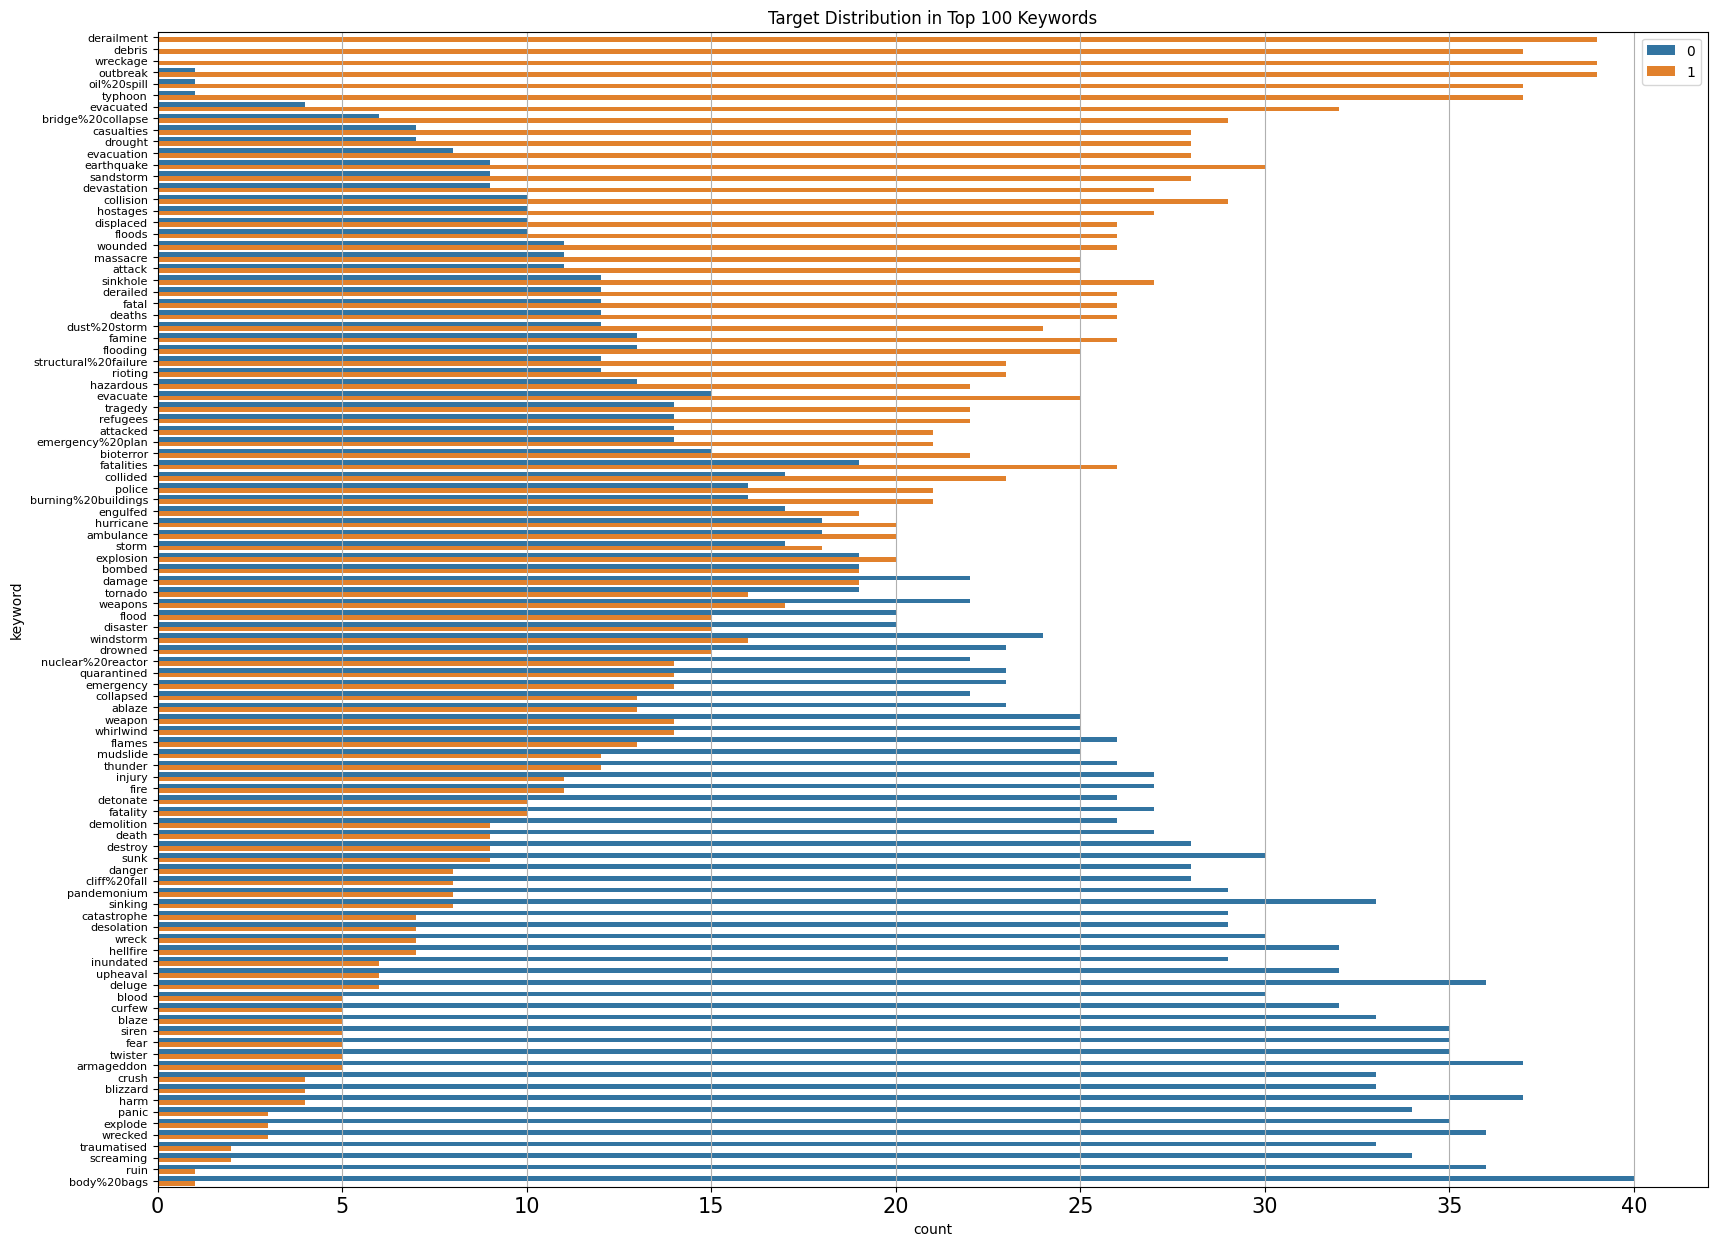

In [8]:
df['target_mean'] = df.groupby('keyword')['target'].transform('mean')

# Sort the dataframe once
df_sorted = df.sort_values(by='target_mean', ascending=False)

# Only take the top N keywords for visualization
top_n = 100
top_keywords = df_sorted['keyword'].value_counts().index[:top_n]
df_sorted = df_sorted[df_sorted['keyword'].isin(top_keywords)]

# fig = plt.figure(figsize=(24, 18), dpi=100)
fig = plt.figure(figsize=fig_size, dpi=100)

sns.countplot(y=df_sorted['keyword'],
              hue=df_sorted['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=8)
plt.legend(loc=1)
plt.title('Target Distribution in Top {} Keywords'.format(top_n))

plt.show()

df.drop(columns=['target_mean'], inplace=True)


C:\Users\delst\AppData\Local\Temp\ipykernel_4668\3366786402.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticklabels=[0,5,10,15,20,25,30,35,40])


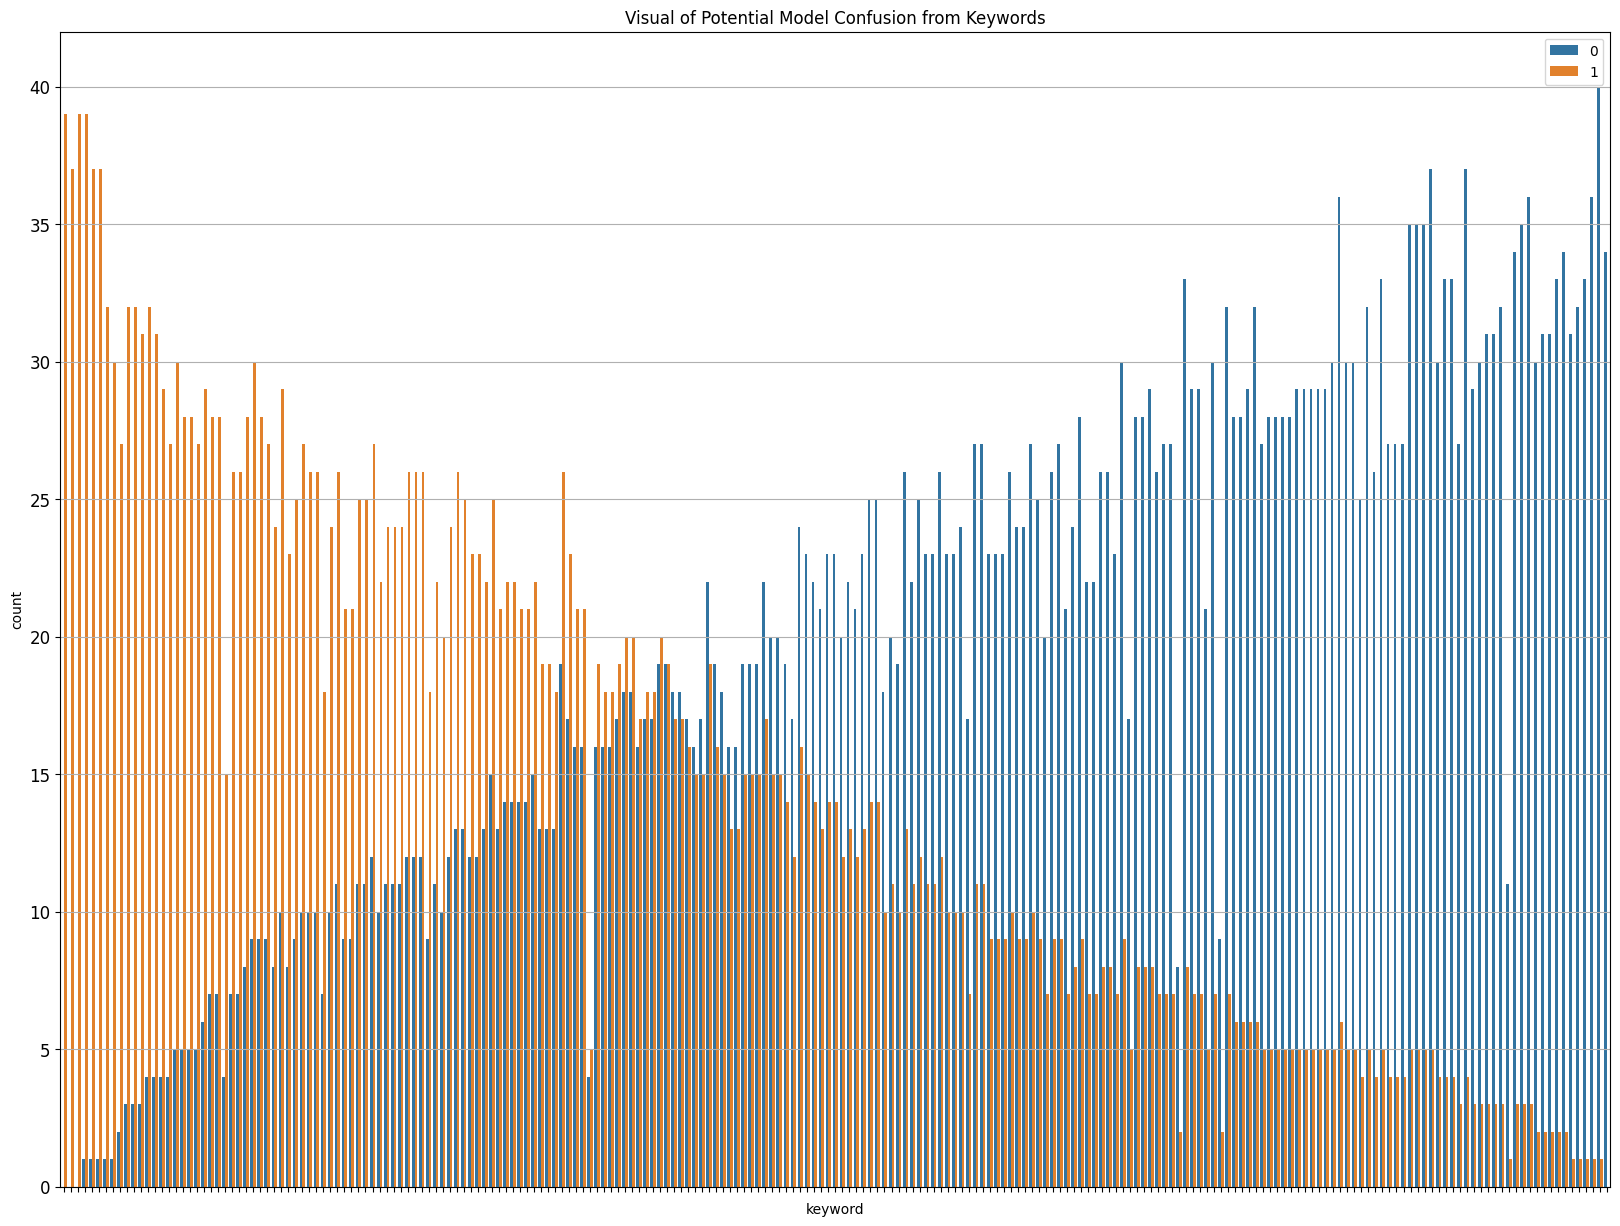

In [9]:
df['target_mean'] = df.groupby('keyword')['target'].transform('mean')

# Sort the dataframe once
df_sorted = df.sort_values(by='target_mean', ascending=False)

# Only take the top N keywords for visualization
top_n = 221
top_keywords = df_sorted['keyword'].value_counts().index[:top_n]
df_sorted = df_sorted[df_sorted['keyword'].isin(top_keywords)]

fig = plt.figure(figsize=fig_size, dpi=100)

ax = sns.countplot(x=df_sorted['keyword'],
                   hue=df_sorted['target'])

# Remove y-axis labels
ax.set(yticklabels=[0,5,10,15,20,25,30,35,40])
ax.set(xticklabels=[])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Visual of Potential Model Confusion from Keywords')

plt.show()

df.drop(columns=['target_mean'], inplace=True)


---

# **Processing**

In [10]:
df['text'] = df['text'].apply(contractions.fix)

In [11]:
tokenizer = TweetTokenizer()
df['tokens'] = df['text'].apply(tokenizer.tokenize)

In [12]:
class TextProcessor:
    def __init__(self, df, token_col):
        self.df = df
        self.token_col = token_col
        self.stop_words = set(stopwords.words('english'))
        
        self.corpus_stopwords = None
        self.corpus_doc_raw = None
        self.corpus_word_raw = None
        self.corpus_doc = None
        self.corpus_word = None

    def remove_stop_words(self, tokens):
        remove_stopwords = [token for token in tokens if token not in stop_words]
        return remove_stopwords
    
    def generate_corpus(self):        
        
        self.corpus_doc_raw = self.df[self.token_col].tolist()
        self.corpus_word_raw = self.df[self.token_col].explode().tolist()
        self.corpus_stopwords = [word for word in self.corpus_word_raw if word in self.stop_words]
        
        self.df[self.token_col] = self.df[self.token_col].apply(self.remove_stop_words)

        self.corpus_doc = self.df[self.token_col].tolist()
        self.corpus_word = self.df[self.token_col].explode().tolist()
    
    def generate_bow(self, corpus):
        self.bow = set(corpus)
        self.bow_fd = FreqDist(corpus)

In [13]:
def create_processor(df, target_val, token_col):
    df_target = df[df['target'] == target_val]
    processor = TextProcessor(df_target, token_col)
    processor.generate_corpus()
    return processor

processor_1 = create_processor(df, 1, 'tokens')
processor_0 = create_processor(df, 0, 'tokens')

C:\Users\delst\AppData\Local\Temp\ipykernel_4668\3039849468.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[self.token_col] = self.df[self.token_col].apply(self.remove_stop_words)


In [14]:
corpus_doc_1 = processor_1.corpus_doc
corpus_word_1 = processor_1.corpus_word
corpus_stopwords_1 = processor_1.corpus_stopwords

corpus_doc_0 = processor_0.corpus_doc
corpus_word_0 = processor_0.corpus_word
corpus_stopwords_0 = processor_0.corpus_stopwords

In [15]:
processor_1.generate_bow(corpus_stopwords_1)
bow_stopwords_1 = processor_1.bow
bow_fd_stopwords_1 = processor_1.bow_fd

processor_0.generate_bow(corpus_stopwords_0)
bow_stopwords_0 = processor_0.bow
bow_fd_stopwords_0 = processor_0.bow_fd

---

In [16]:
def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=100,
        max_font_size=60,
        scale=3,
        random_state=1,
        collocations=False
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12,15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.title(title)  
    plt.show()


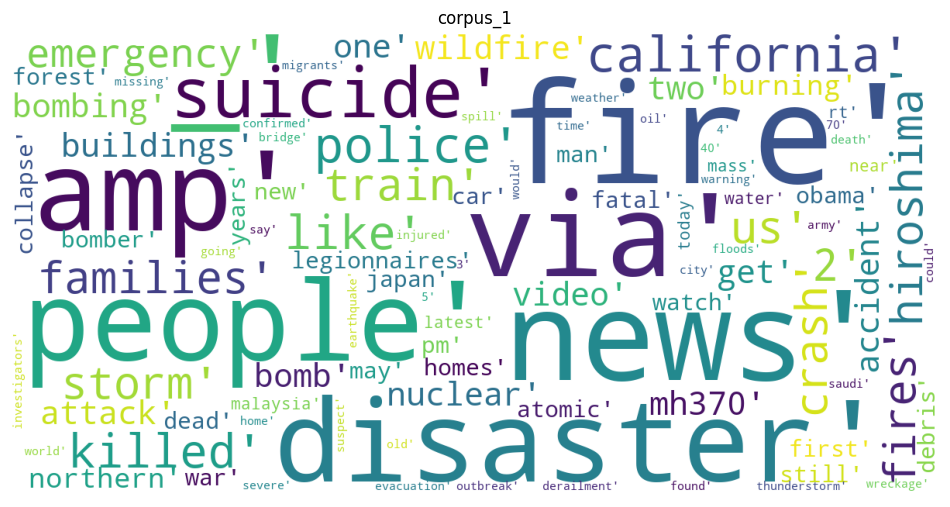

In [17]:
show_wordcloud(corpus_word_1, 'corpus_1')

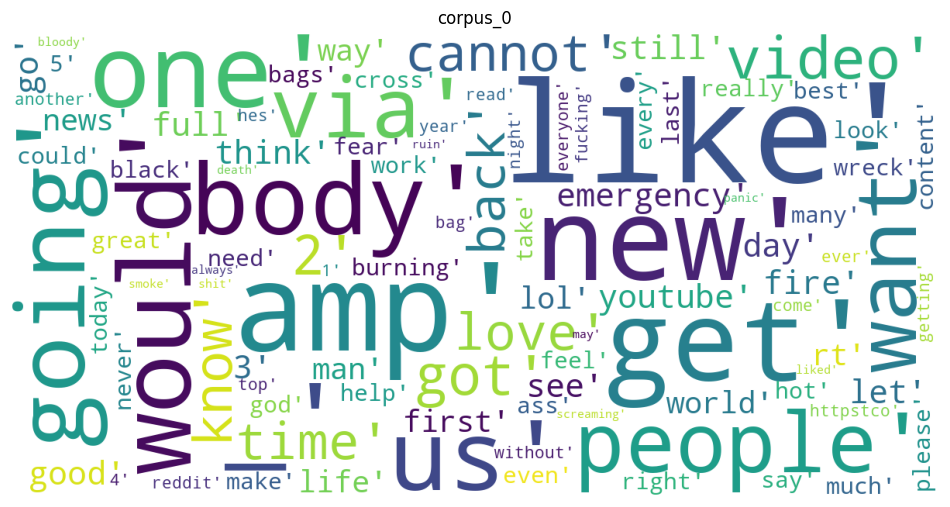

In [18]:
show_wordcloud(corpus_word_0, 'corpus_0')

In [19]:
show_wordcloud(corpus_stopwords)

NameError: name 'corpus_stopwords' is not defined

In [ ]:
bow_fd_stopwords

FreqDist({'the': 3234, 'a': 2153, 'to': 2028, 'in': 1956, 'of': 1823, 'i': 1698, 'and': 1402, 'is': 1130, 'you': 998, 'for': 883, ...})

In [ ]:
# get all the occurences of 'the' from a list of lists
def get_occurences(corpus, word):
    occurences = 0
    for tweet in corpus:
        occurences += tweet.count(word)
    return occurences
get_occurences(bow, "they")

4

---

In [ ]:
# a function to remove single characters from a tokenized list
def remove_single_char(token_lists):
    return [[token for token in tokens if len(token) > 1] for tokens in token_lists]

corpus_ngram = remove_single_char(corpus_doc)
corpus_ngram

[['@bbcmtd', 'wholesale', 'markets', 'ablaze'],
 ['always', 'try', 'bring', 'heavy', '#metal', '#rt'],
 ['#africanbaze', 'breaking', 'newsnigeria', 'flag', 'set', 'ablaze', 'aba'],
 ['crying', 'set', 'ablaze'],
 ['plus', 'side', 'look', 'sky', 'last', 'night', 'ablaze'],
 ['@phdsquares',
  '#mufc',
  'built',
  'much',
  'hype',
  'around',
  'new',
  'acquisitions',
  'doubt',
  'set',
  'epl',
  'ablaze',
  'season'],
 ['inec', 'office', 'abia', 'set', 'ablaze'],
 ['barbados',
  '#bridgetown',
  'jamaica',
  'ûò',
  'two',
  'cars',
  'set',
  'ablaze',
  'santa',
  'cruz',
  'ûó',
  'head',
  'st',
  'elizabeth',
  'police',
  'superintende'],
 ['ablaze', 'lord'],
 ['check', '#nsfw'],
 ['outside', 'ablaze', 'alivebut', 'dead', 'inside'],
 ['awesome',
  'time',
  'visiting',
  'cfc',
  'head',
  'office',
  'ancop',
  'site',
  'ablaze',
  'thanks',
  'tita',
  'vida',
  'taking',
  'care',
  'us'],
 ['soooo', 'pumped', 'ablaze', '@southridgelife'],
 ['wanted', 'set', 'chicago', 'abl

In [ ]:
def generate_bigrams(text_list):
    # Assume that text_list is a list of tokens for each document
    bigrams_list = [list(bigrams(tokens)) for tokens in text_list]
    return bigrams_list

def generate_trigrams(text_list):
    # Assume that text_list is a list of tokens for each document
    trigrams_list = [list(trigrams(tokens)) for tokens in text_list]
    return trigrams_list

In [ ]:
corpus_bigrams = generate_bigrams(corpus_ngram)
corpus_trigrams = generate_trigrams(corpus_ngram)

In [ ]:
corpus_bigrams = sum(corpus_bigrams, [])
corpus_trigrams = sum(corpus_trigrams, [])

fd_bigrams = FreqDist(corpus_bigrams)
fd_trigrams = FreqDist(corpus_trigrams)

In [ ]:
print("Most common bigrams:", fd_bigrams.most_common(10))
print("Most common trigrams:", fd_trigrams.most_common(10))

Most common bigrams: [(('suicide', 'bomber'), 56), (('burning', 'buildings'), 55), (('liked', '@youtube'), 41), (('@youtube', 'video'), 41), (('northern', 'california'), 40), (('cross', 'body'), 39), (('oil', 'spill'), 38), (('let', 'us'), 34), (('looks', 'like'), 33), (('suicide', 'bombing'), 33)]
Most common trigrams: [(('liked', '@youtube', 'video'), 41), (('northern', 'california', 'wildfire'), 28), (('suicide', 'bomber', 'detonated'), 28), (('latest', 'homes', 'razed'), 27), (('homes', 'razed', 'northern'), 27), (('pkk', 'suicide', 'bomber'), 27), (('bomber', 'detonated', 'bomb'), 27), (('families', 'sue', 'legionnaires'), 26), (('40', 'families', 'affected'), 26), (('families', 'affected', 'fatal'), 26)]


TypeError: unhashable type: 'numpy.ndarray'

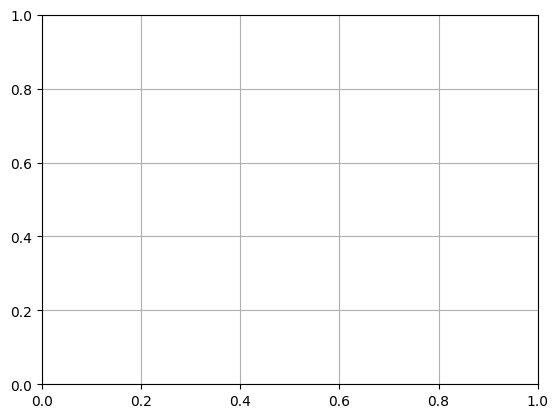

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')


plt.show()
